In [9]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.utils import VotingSchemas, VotingArray
from src.outcomes import *
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
import os
import numpy as np
from random import choices, shuffle
from collections import Counter
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.utils import VotingSchemas
from src.outcomes import *
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
from src.coalitions import find_stable_coalitions_by_compromising
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
debug = True

num_voters = 1_300_000
alternatives = {
    "PVV": 2.349,
    "GL/Pvda": 1.557,
    "VDD": 1.524,
    "NSC": 1.288,
    "D66": 0.629,
    "BBB": 0.4650000000000001,
    "CDA": 0.33099999999999996,
    "SP": 0.315,
    "Denk": 0.273,
    "Others": 1.269,
}

alternatives_alignment = {
    "PVV": "right",
    "GL/Pvda": "left",
    "VDD": "center-right",
    "NSC": "center-right",
    "D66": "center",
    "BBB": "right",
    "CDA": "right",
    "SP": "left",
    "Denk": "center-left",
    "Others": "center",
}

position_votes = {
    "center": alternatives["D66"] + alternatives["Others"],
    "left": alternatives["GL/Pvda"] + alternatives["Denk"],
    "right": alternatives["PVV"]
    + alternatives["VDD"]
    + alternatives["NSC"]
    + alternatives["BBB"]
    + alternatives["CDA"]
}

first_preference = choices(
    list(alternatives.keys()), weights=alternatives.values(), k=num_voters
)

if debug:
    votes_counts = Counter(first_preference)
    percentage_count = {k: v / num_voters for k, v in votes_counts.items()}
    sim = {
        key: percentage_count[key] * 10
        for key in alternatives.keys()
        if key in percentage_count
    }

    print(sim)


def get_matching_alternatives(fp, alternatives_alignment):
    if alternatives_alignment[fp] == "center":
        alternatives = list(alternatives_alignment.keys())
        alternatives.remove(fp)
        shuffle(alternatives)
        return alternatives

    aligment = alternatives_alignment[fp].replace("center-", "")
    first_preferences = [k for k, v in alternatives_alignment.items() if aligment in v]
    first_preferences.remove(fp)
    shuffle(first_preferences)

    last_preferences = [
        k for k, v in alternatives_alignment.items() if not aligment in v
    ]
    shuffle(last_preferences)
    return first_preferences + last_preferences


voting = np.empty((len(alternatives), num_voters), dtype="U32")
for i, fp in enumerate(first_preference):
    valternatives = get_matching_alternatives(fp, alternatives_alignment)
    valternatives.insert(0, fp)
    voting[:, i] = np.array(valternatives)

voting = voting.view(VotingArray)

{'PVV': 2.3463076923076924, 'GL/Pvda': 1.5597153846153846, 'VDD': 1.5190846153846156, 'NSC': 1.285146153846154, 'D66': 0.6318461538461538, 'BBB': 0.46649999999999997, 'CDA': 0.3330230769230769, 'SP': 0.3144692307692307, 'Denk': 0.27276923076923076, 'Others': 1.2711384615384616}


In [5]:
a = pd.DataFrame(
    (voting.to_pandas().T["preference_0"].value_counts() / num_voters)*100
).reset_index().rename(columns={"count": "% Simulation", "preference_0": "Party"})

b = pd.DataFrame(columns=["Party", "% Original"])
b["Party"] = alternatives.keys()
b["% Original"] = list(alternatives.values())
b["% Original"] = b["% Original"]*10

print(a.merge(b, on="Party").to_latex(index=False))

\begin{tabular}{lrr}
\toprule
Party & % Simulation & % Original \\
\midrule
PVV & 23.463077 & 23.490000 \\
GL/Pvda & 15.597154 & 15.570000 \\
VDD & 15.190846 & 15.240000 \\
NSC & 12.851462 & 12.880000 \\
Others & 12.711385 & 12.690000 \\
D66 & 6.318462 & 6.290000 \\
BBB & 4.665000 & 4.650000 \\
CDA & 3.330231 & 3.310000 \\
SP & 3.144692 & 3.150000 \\
Denk & 2.727692 & 2.730000 \\
\bottomrule
\end{tabular}



In [6]:
outcomes = all_schemas_outcomes(voting)
outcomes_df = all_schemas_outcomes_to_pandas(outcomes)
outcomes_df

,BBB,CDA,D66,Denk,GL/Pvda,NSC,Others,PVV,SP,VDD,Winner
Plurality Voting,60645,43293,82140,35460,202763,167069,165248,305020,40881,197481,PVV
Voting for Two,266508,253675,100573,184592,268314,346539,174297,449211,187516,368775,PVV
Veto Voting,1232339,1232384,1087054,1118523,1118103,1232510,1096065,1232875,1117586,1232561,PVV
Borda Voting,7008440,6960956,3785903,4683030,4931274,7272261,4202008,7618187,4692725,7345216,PVV


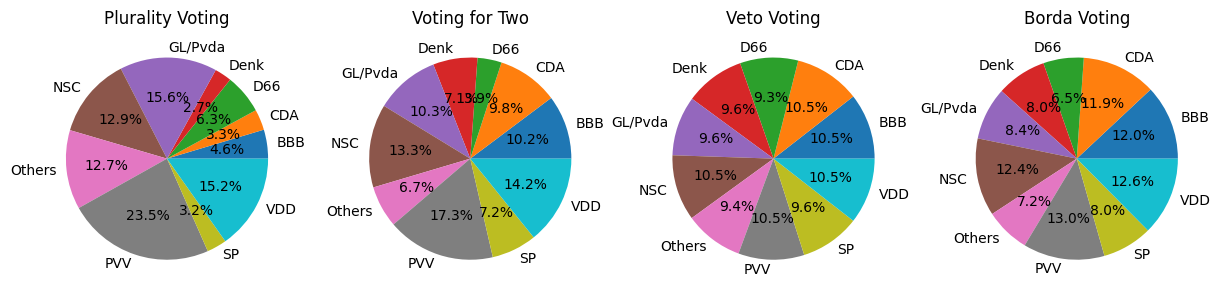

In [28]:

fig, ax = plt.subplots(ncols=4, figsize=(15,10))
ax[0].title.set_text("Plurality Voting")
ax[0].pie(outcomes_df.T["Plurality Voting"].values[:-1], labels=outcomes_df.T.index[:-1], autopct='%1.1f%%')

ax[1].title.set_text("Voting for Two")
ax[1].pie(
    outcomes_df.T["Voting for Two"].values[:-1],
    labels=outcomes_df.T.index[:-1],
    autopct="%1.1f%%",
)

ax[2].title.set_text("Veto Voting")
ax[2].pie(
    outcomes_df.T["Veto Voting"].values[:-1],
    labels=outcomes_df.T.index[:-1],
    autopct="%1.1f%%",
)

ax[3].title.set_text("Borda Voting")
ax[3].pie(
    outcomes_df.T["Borda Voting"].values[:-1],
    labels=outcomes_df.T.index[:-1],
    autopct="%1.1f%%",
)
fig.show()

Voters Happiness Level


,Happiness Level
0,1.000000
1,0.528920
2,0.000000
3,1.000000
4,0.589513
...,...
1299995,0.471080
1299996,1.000000
1299997,0.471080
1299998,0.339757



Overall Happiness Level: 815170.9129783813

Happiness Level Distribution


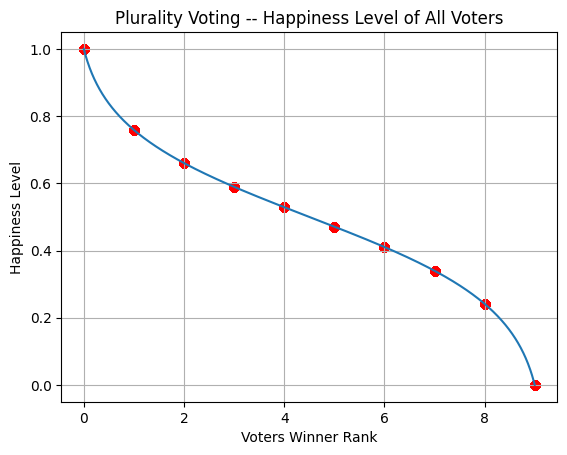


Histogram of Happiness Level


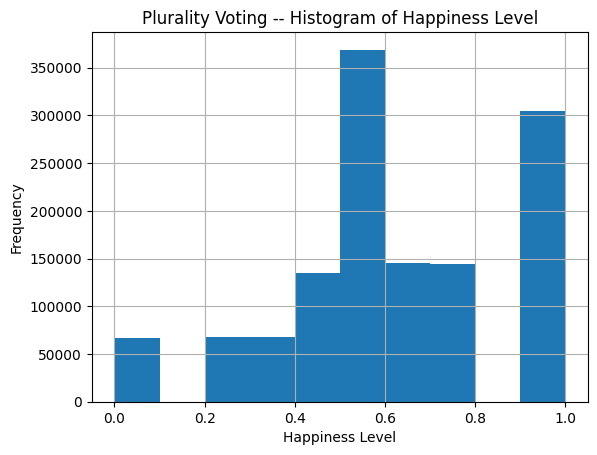

,Happiness Level,Party,Position
0,1.000000,PVV,right
1,0.528920,GL/Pvda,left
2,0.000000,SP,left
3,1.000000,PVV,right
4,0.589513,VDD,center-right
...,...,...,...
1299995,0.471080,GL/Pvda,left
1299996,1.000000,PVV,right
1299997,0.471080,GL/Pvda,left
1299998,0.339757,SP,left


In [7]:
pv_h = HappinessLevel(
    voting,
    outcomes[VotingSchemas.PLURALITY_VOTING.value].winner,
    VotingSchemas.PLURALITY_VOTING,
).run(show=True)

table = pv_h.happiness_level_pandas()
table["Party"] = voting.to_pandas().loc["preference_0"].values
table["Position"] = table["Party"].apply(lambda x: alternatives_alignment[x])
table

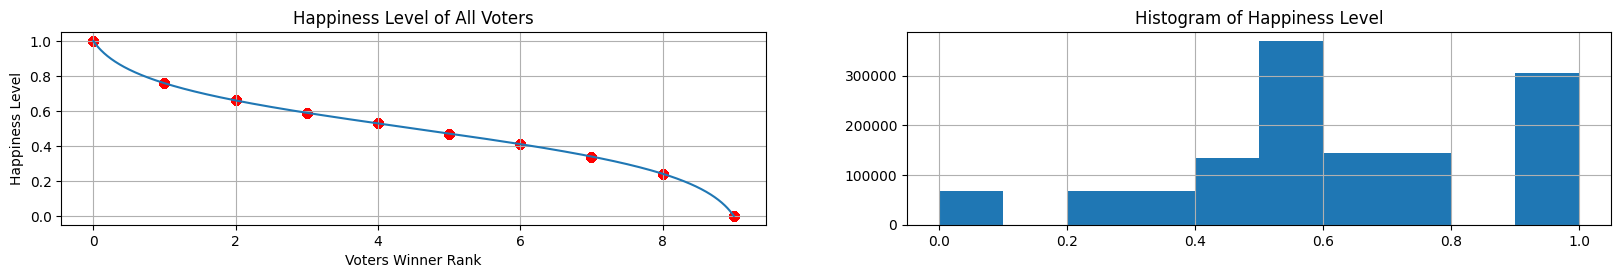

In [10]:
pv_h.both()

In [12]:
table[["Happiness Level", "Position"]].groupby("Position").mean().reset_index().T

,0,1,2,3,4
Position,center,center-left,center-right,left,right
Happiness Level,0.444904,0.368732,0.634169,0.368775,0.907173


In [13]:
print(table[["Happiness Level", "Position"]].groupby("Position").mean().reset_index().T.to_latex())

\begin{tabular}{llllll}
\toprule
 & 0 & 1 & 2 & 3 & 4 \\
\midrule
Position & center & center-left & center-right & left & right \\
Happiness Level & 0.444904 & 0.368732 & 0.634169 & 0.368775 & 0.907173 \\
\bottomrule
\end{tabular}



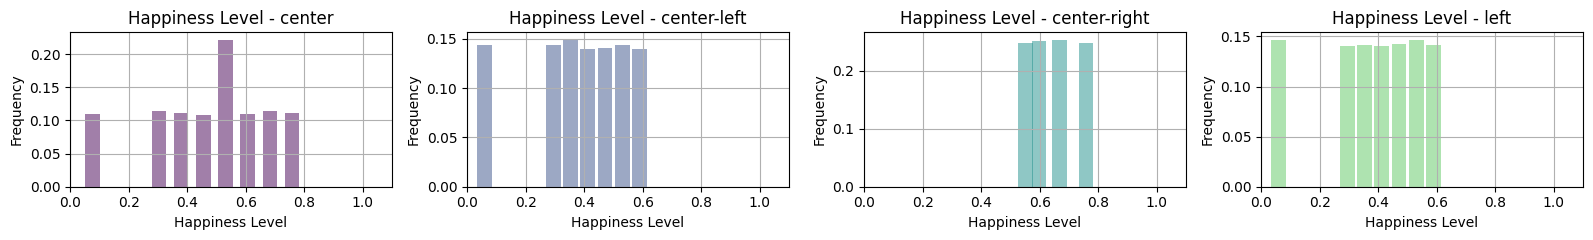

In [ ]:
splits = [t for t in table.groupby("Position")]
label = [t[0] for t in splits]
values = [t[1]["Happiness Level"].values for t in splits]

colors = plt.cm.viridis(np.linspace(0, 1, len(label)))
c = 0
fig, ax = plt.subplots(1,5, figsize=(20,2.5))
for v, l in zip(values, label):
    counts, bins = np.histogram(v)
    ax.flat[c].bar(
        bins[1:],
        counts / counts.sum(),
        color=colors[c],
        label=l,
        alpha=0.5,
        width=0.05,
        align="center",
    )
    ax.flat[c].set_title(f"Happiness Level - {l}")
    ax.flat[c].set_xlabel("Happiness Level")
    ax.flat[c].set_ylabel("Frequency")
    ax.flat[c].set_xlim(0, 1.1)
    ax.flat[c].grid()
    c += 1

ax.flat[-1].set_visible(False)  # to remove last plot
fig.tight_layout()
fig.show()

In [44]:
position_votes = {
    "center": alternatives["D66"] + alternatives["Others"],
    "left": alternatives["GL/Pvda"] + alternatives["Denk"],
    "right": alternatives["PVV"]
    + alternatives["VDD"]
    + alternatives["NSC"]
    + alternatives["BBB"]
    + alternatives["CDA"],
}

first_preference = choices(
    list(position_votes.keys()), weights=position_votes.values(), k=13000
)

def get_matching_alternatives_position(fp, position_votes):
    alternatives = list(position_votes.keys())
    alternatives.remove(fp)
    shuffle(alternatives)
    return alternatives

voting_position = np.empty((len(position_votes), 13000), dtype="U32")
for i, fp in enumerate(first_preference):
    valternatives = get_matching_alternatives_position(fp, position_votes)
    valternatives.insert(0, fp)
    voting_position[:, i] = np.array(valternatives)

voting_position = voting_position.view(VotingArray)

In [45]:
po = all_schemas_outcomes(voting_position)

ppv_h = HappinessLevel(
    voting_position,
    po[VotingSchemas.PLURALITY_VOTING.value].winner,
    VotingSchemas.PLURALITY_VOTING,
).run(show=False)

In [46]:
from src.coalitions import find_stable_coalitions_by_compromising

c_pv = find_stable_coalitions_by_compromising(
    5000,
    pd.DataFrame(voting_position).T,
    ppv_h,
    po[VotingSchemas.PLURALITY_VOTING.value],
    VotingSchemas.PLURALITY_VOTING,
    plurality_outcome,
)

display(c_pv)

Voters Happiness Level


,Happiness Level
0,0.528920
1,0.339757
2,0.528920
3,0.410487
4,0.241228
...,...
195,1.000000
196,0.589513
197,1.000000
198,0.589513



Overall Happiness Level: 0.6180573898866824

Happiness Level Distribution


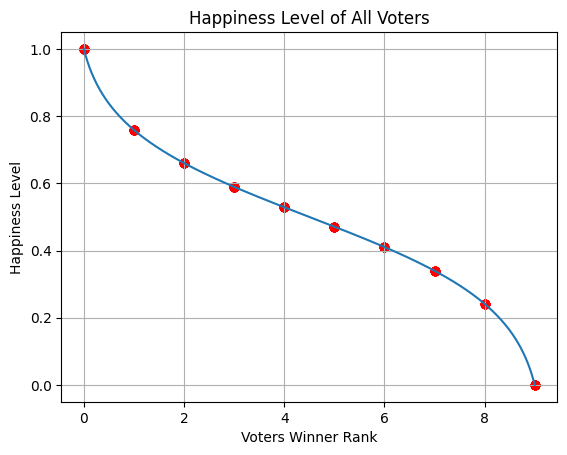


Histogram of Happiness Level


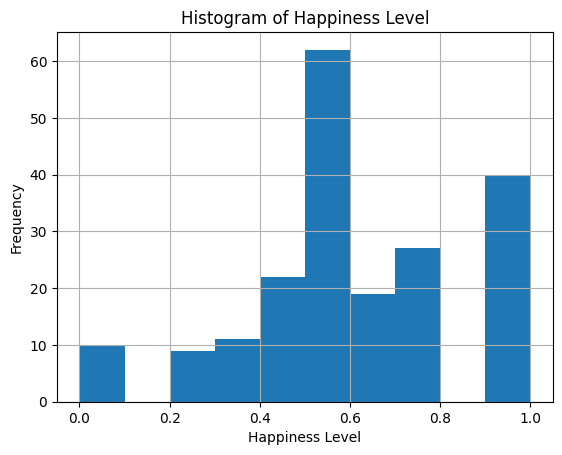

In [9]:
vt_h = HappinessLevel(
    voting,
    outcomes[VotingSchemas.VOTING_FOR_TWO.value].winner,
    VotingSchemas.VOTING_FOR_TWO,
).run(show=True)

Voters Happiness Level


,Happiness Level
0,0.660243
1,0.589513
2,1.000000
3,0.528920
4,0.471080
...,...
195,0.528920
196,0.471080
197,0.528920
198,0.410487



Overall Happiness Level: 0.6186288520829849

Happiness Level Distribution


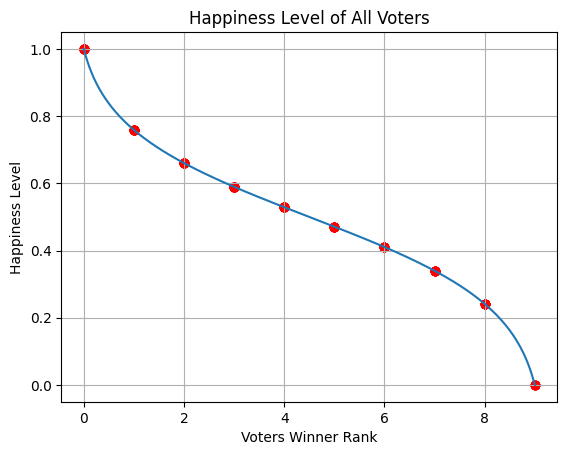


Histogram of Happiness Level


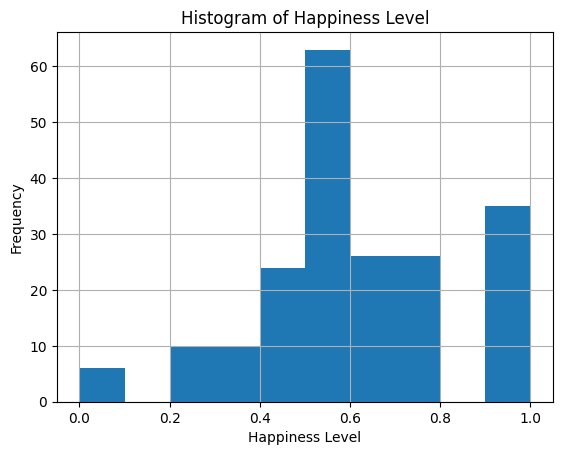

In [10]:
bv_h = HappinessLevel(
    voting,
    outcomes[VotingSchemas.BORDA_VOTING.value].winner,
    VotingSchemas.BORDA_VOTING,
).run(show=True)

In [11]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

In [12]:
voting = utils.read_voting(path_voting, table_name="voting5")
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


## Strategic Voting

In [13]:
result = plurality_outcome(voting)
result

{'A': 1, 'B': 2, 'C': 3, 'D': 0}

Note that **voter 5** is the only voter that can engage in strategic voting. Voter 5 prefers $B$ over the winner $C$. Hence, they can increase their $\text{Happiness Level}$ by placing $B$ as their first preference, resulting in a tie between $C$ and $B$ in the voting outcome (for plurality, voting for two, Borda). Since ties are resolved in alphabetical order, $B$ wins over $C$.

The table below displays the two voting strategies available to voter 5.

In [14]:
happiness_level = HappinessLevel(voting, result.winner, VotingSchemas.PLURALITY_VOTING).run()
strategic_voting = StrategicVoting(voting, happiness_level, plurality_outcome).run(show=True)

Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,0.470162,0.568414
1,5,"[B, D, A, C]",B,0.410487,0.0,0.470162,0.568414


Best Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,0.470162,0.568414


Risk: 0.13682886358890622


The table displays the best strategic voting for each voter

In [15]:
strategic_voting.best

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,0.470162,0.568414


Strategic Voting Risk

In [16]:
strategic_voting.risk

0.13682886358890622